## Toronto Bikes JSON

In [1]:
import pandas as pd, requests, json, numpy as np, seaborn as sns

#### Read In
Getting bike data from online JSON

In [273]:

bike_request = requests.get("https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status")
bike_dict= json.loads(bike_request.text)
stations_dict=bike_dict['data']['stations']
bike_frame = pd.DataFrame.from_dict(stations_dict)


#### Cleaning
First, let's look at summary statistics of the data to examine potential problems. It seems that most values are reasonable. There may be outliers but we'll look at that later. A few variables are categorical but they already are 0's and 1's and the variable names are pretty intuitive, so we'll just leave them.
###### Missing Data
All columns have 363 observations, so it looks like there is no missing data

In [274]:
bike_frame.describe().round(2)

,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled
count,363.00,363.00,363.00,3.630000e+02,363.00,363.00,363.00,363.00
mean,0.99,0.99,0.99,1.527632e+09,7.68,0.34,8.90,0.09
std,0.07,0.12,0.12,1.807846e+08,5.75,0.55,5.27,0.31
min,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,1.548969e+09,3.00,0.00,5.00,0.00
50%,1.00,1.00,1.00,1.548969e+09,7.00,0.00,8.00,0.00
75%,1.00,1.00,1.00,1.548969e+09,11.00,1.00,12.00,0.00
max,1.00,1.00,1.00,1.548969e+09,38.00,2.00,28.00,2.00


There may be other variables that aren't numerica we want to alter. It looks like there are a few. For consistency, it would probably be helpful to convert is charing station to a boolean. Station_id is probably a simple id variable. Let's look further at the num_bikes_available types variable though.

In [275]:
bike_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 11 columns):
is_charging_station          363 non-null bool
is_installed                 363 non-null int64
is_renting                   363 non-null int64
is_returning                 363 non-null int64
last_reported                363 non-null int64
num_bikes_available          363 non-null int64
num_bikes_available_types    363 non-null object
num_bikes_disabled           363 non-null int64
num_docks_available          363 non-null int64
num_docks_disabled           363 non-null int64
station_id                   363 non-null object
dtypes: bool(1), int64(8), object(2)
memory usage: 28.8+ KB


In [276]:
bike_frame['is_charging_station'] = bike_frame.is_charging_station.astype('int64')
bike_frame.describe()

,is_charging_station,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled
count,363.0,363.000000,363.000000,363.000000,3.630000e+02,363.000000,363.000000,363.000000,363.000000
mean,0.0,0.994490,0.986226,0.986226,1.527632e+09,7.683196,0.344353,8.898072,0.088154
std,0.0,0.074124,0.116713,0.116713,1.807846e+08,5.750467,0.551131,5.270377,0.311737
min,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,1.000000,1.000000,1.548969e+09,3.000000,0.000000,5.000000,0.000000
50%,0.0,1.000000,1.000000,1.000000,1.548969e+09,7.000000,0.000000,8.000000,0.000000
75%,0.0,1.000000,1.000000,1.000000,1.548969e+09,11.000000,1.000000,12.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.548969e+09,38.000000,2.000000,28.000000,2.000000


Looks like this contains additional information: how many e-bikes and mechanical bikes. Let's try to get these as separate variables

In [277]:
bike_frame["num_bikes_available_types"].head()

0     {'mechanical': 9, 'ebike': 0}
1    {'mechanical': 11, 'ebike': 0}
2     {'mechanical': 4, 'ebike': 0}
3     {'mechanical': 0, 'ebike': 0}
4     {'mechanical': 2, 'ebike': 0}
Name: num_bikes_available_types, dtype: object

In [278]:
df = pd.DataFrame({'ebike': [bike_frame.num_bikes_available_types[0]['ebike']]})
shortened = bike_frame.num_bikes_available_types[1:len(bike_frame.num_bikes_available_types)]
for  idx in range(1,len(shortened)+1):
    test = pd.DataFrame({'ebike': [shortened[idx]['ebike']]})
    df = pd.concat([df,test])
    
df2 = pd.DataFrame({'mechanical': [bike_frame.num_bikes_available_types[0]['mechanical']]})
shortened = bike_frame.num_bikes_available_types[1:len(bike_frame.num_bikes_available_types)]
for  idx in range(1,len(shortened)+1):
    test = pd.DataFrame({'mechanical': [shortened[idx]['mechanical']]})
    df2 = pd.concat([df2,test])
    
    
 

In [279]:
df= pd.concat([df, df2], axis=1)
df= df.reset_index()
bike_frame = pd.concat([bike_frame, df], axis=1)
bike_frame = bike_frame.drop(columns=['index'])

As we look at these variables, it seems like there are no charging station, and there are only mechanical bikes. Additionally, the number of bikes available seems to always refer to mechanical bikes. Perhaps toronto has plans to add this in the future, but for now we can probably remove charging station, ebike, and mechanical from our data

In [280]:
bike_frame.describe()

,is_charging_station,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,ebike,mechanical
count,363.0,363.000000,363.000000,363.000000,3.630000e+02,363.000000,363.000000,363.000000,363.000000,363.0,363.000000
mean,0.0,0.994490,0.986226,0.986226,1.527632e+09,7.683196,0.344353,8.898072,0.088154,0.0,7.683196
std,0.0,0.074124,0.116713,0.116713,1.807846e+08,5.750467,0.551131,5.270377,0.311737,0.0,5.750467
min,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,1.000000,1.000000,1.000000,1.548969e+09,3.000000,0.000000,5.000000,0.000000,0.0,3.000000
50%,0.0,1.000000,1.000000,1.000000,1.548969e+09,7.000000,0.000000,8.000000,0.000000,0.0,7.000000
75%,0.0,1.000000,1.000000,1.000000,1.548969e+09,11.000000,1.000000,12.000000,0.000000,0.0,11.000000
max,0.0,1.000000,1.000000,1.000000,1.548969e+09,38.000000,2.000000,28.000000,2.000000,0.0,38.000000


In [281]:
#What percent of the bikes avaialble variables match the number of mechanical bikes available. 
print(np.mean(bike_frame['num_bikes_available']==bike_frame['mechanical'])*100, "%")

100.0 %


In [282]:
bike_frame = bike_frame.drop(columns=['is_charging_station', 'mechanical', 'ebike'])

Now let's look at each variable for normality and outliers. Looks like reported is a number in minutes originating from some point in time, but that's only a guess. I had to filter the number to keep out some that made it difficult to see the histogram, so I probably want to examine outliers.

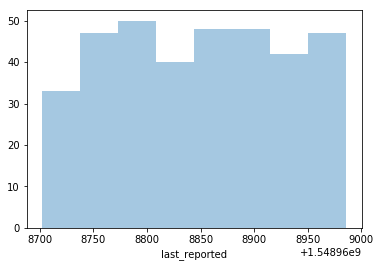

In [289]:
sns.distplot(bike_frame['last_reported'][bike_frame.last_reported>1548968000], kde=False)

In [290]:

a=bike_frame['last_reported']
subj_upbound=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
subj_lowbound=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print(subj_upbound, subj_lowbound)
print(np.max(bike_frame['last_reported'])<subj_upbound) #looks like our max is less than our upperbound
print(bike_frame['last_reported'].quantile(.01)) # but the 1%ile is 0, so we have a few that are zero
outliers_reported = bike_frame['last_reported'][bike_frame['last_reported']<subj_lowbound]
print("There are", len(outliers_reported), "outliers")
print(subj_lowbound-outliers_reported)

1548969123.0 1548968573.0
True
0.0
There are 8 outliers
159    1.548969e+09
242    1.548969e+09
278    1.548969e+09
297    1.548969e+09
313    1.088300e+04
338    2.281870e+05
351    5.266000e+04
361    1.548969e+09
Name: last_reported, dtype: float64


Looks like the outliers are either 0 or else thousands away from the others (which are only hundreds away from each other). We probably want to create a variable that replaces these with the fenced value and try both.

In [291]:
bike_frame['fenced_report']=bike_frame['last_reported']
bike_frame['fenced_report'][bike_frame['last_reported']<subj_lowbound]=subj_lowbound

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Num_bikes_disabled
Looks like all have less than 3 bikes disabled. There aren't really outliers here. 

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


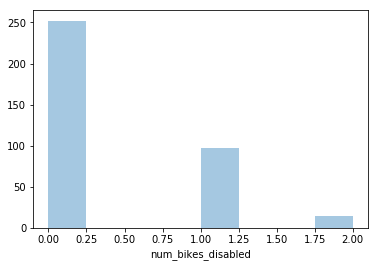

In [292]:
sns.distplot(bike_frame['num_bikes_disabled'], kde=False)

#### Num_docks_disabled
Looks like most no docks disabled, but a few have 1 or 2. Fencing would make no sense

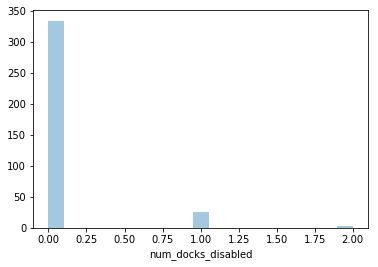

In [294]:
sns.distplot(bike_frame['num_docks_disabled'], kde=False)

#### Num_bikes_available
Looks quite skewed. We may want to fence the upper outliers, as I don't know if they are qualitatively different from other high bike missing areas. We want both variables in this case

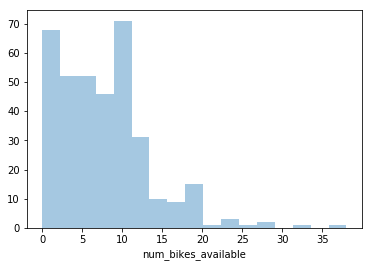

In [295]:
sns.distplot(bike_frame['num_bikes_available'], kde=False)

In [296]:
a=bike_frame['num_bikes_available']
bike_upbound=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
bike_lowbound=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print(bike_upbound, bike_lowbound)
bike_frame['fenced_bikes']=bike_frame['num_bikes_available']
bike_frame['fenced_bikes'][bike_frame['num_bikes_available']>bike_upbound]=bike_upbound

23.0 -9.0


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Number of docks available

Based on the histogram, there is a slight skew. There are a few outliers over the high bound, but I think just one is above 23. Let's just fence this one. It shouldn't matter a huge deal thouh

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


22.0 -6.0
23.0


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


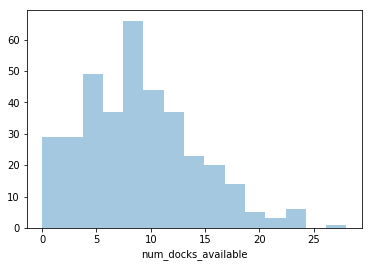

In [297]:
sns.distplot(bike_frame['num_docks_available'], kde=False)
a=bike_frame['num_docks_available']
docks_up=2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
docks_low=-2*(a.quantile(.75)-a.quantile(.25))+a.quantile(.50)
print(docks_up, docks_low)
print(bike_frame['num_docks_available'].quantile(.99))
bike_frame['fenced_docks']=bike_frame['num_docks_available']
bike_frame['fenced_docks'][bike_frame['num_docks_available']>docks_up]=docks_up

## Describing Data
First, let's just have a simple tale with summary statistics. Of note, the majority of stations are installed and returning and renting, so comparing those that don't may be an interesting table.

In [298]:
bike_frame.describe()

,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,fenced_report,fenced_bikes,fenced_docks
count,363.000000,363.000000,363.000000,3.630000e+02,363.000000,363.000000,363.000000,363.000000,3.630000e+02,363.000000,363.000000
mean,0.994490,0.986226,0.986226,1.527632e+09,7.683196,0.344353,8.898072,0.088154,1.548969e+09,7.581267,8.862259
std,0.074124,0.116713,0.116713,1.807846e+08,5.750467,0.551131,5.270377,0.311737,8.767252e+01,5.374986,5.168197
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.548969e+09,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.548969e+09,3.000000,0.000000,5.000000,0.000000,1.548969e+09,3.000000,5.000000
50%,1.000000,1.000000,1.000000,1.548969e+09,7.000000,0.000000,8.000000,0.000000,1.548969e+09,7.000000,8.000000
75%,1.000000,1.000000,1.000000,1.548969e+09,11.000000,1.000000,12.000000,0.000000,1.548969e+09,11.000000,12.000000
max,1.000000,1.000000,1.000000,1.548969e+09,38.000000,2.000000,28.000000,2.000000,1.548969e+09,23.000000,22.000000


In [299]:
bike_frame[['num_bikes_available','num_bikes_disabled','num_docks_available','num_docks_disabled', 'last_reported']].groupby(bike_frame['is_installed']).mean()


,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported
is_installed,,,,,
0,0.000000,0.00000,0.000000,0.000000,0.000000e+00
1,7.725762,0.34626,8.947368,0.088643,1.536096e+09


In [300]:
bike_frame[['num_bikes_available','num_bikes_disabled','num_docks_available','num_docks_disabled', 'last_reported']].groupby(bike_frame['is_returning']).mean()

,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported
is_returning,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,7.790503,0.349162,9.022346,0.089385,1.548968e+09


In [301]:
bike_frame[['num_bikes_available','num_bikes_disabled','num_docks_available','num_docks_disabled', 'last_reported']].groupby(bike_frame['is_renting']).mean()


,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported
is_renting,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,7.790503,0.349162,9.022346,0.089385,1.548968e+09


Unsurprisingly, stations that are not renting, returning, or installed have no bikes available, and have the value for last_reported set to zero. Future graphics and tables may just want to use those that are renting and returning. Let's look at these correlations! <br>
Appears that most correlations are close to zero. The exception is that the number of bikes available and number of docks available are negatively correlated:
<br>r=-.5<br>
This make sense

In [302]:
bike_frame_open= bike_frame[bike_frame.is_returning==1]
bike_frame_open[['num_bikes_available','num_bikes_disabled','num_docks_available','num_docks_disabled', 'last_reported']].corr()

,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported
num_bikes_available,1.000000,0.001051,-0.548890,0.086982,0.042512
num_bikes_disabled,0.001051,1.000000,-0.018291,0.061733,0.041746
num_docks_available,-0.548890,-0.018291,1.000000,-0.071622,-0.075279
num_docks_disabled,0.086982,0.061733,-0.071622,1.000000,0.019198
last_reported,0.042512,0.041746,-0.075279,0.019198,1.000000


In [303]:
bike_frame_open[['fenced_bikes','num_bikes_disabled','fenced_docks','num_docks_disabled', 'fenced_report']].corr()

,fenced_bikes,num_bikes_disabled,fenced_docks,num_docks_disabled,fenced_report
fenced_bikes,1.000000,0.002946,-0.579338,0.092036,0.025077
num_bikes_disabled,0.002946,1.000000,-0.024088,0.061733,0.025372
fenced_docks,-0.579338,-0.024088,1.000000,-0.071050,0.034513
num_docks_disabled,0.092036,0.061733,-0.071050,1.000000,0.063523
fenced_report,0.025077,0.025372,0.034513,0.063523,1.000000


## Visualization
I have run some visualizaitons before, but mostly just histograms. Let's look at a few bivariate relationships. 

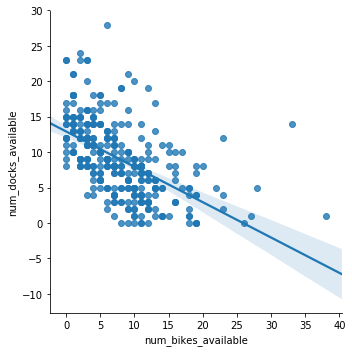

In [261]:
sns.lmplot(x="num_bikes_available", y="num_docks_available", data=bike_frame_open)


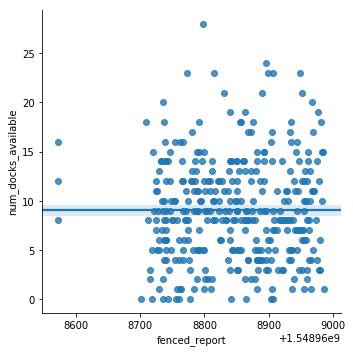

In [264]:
sns.lmplot(x="fenced_report", y="num_docks_available", data=bike_frame_open)


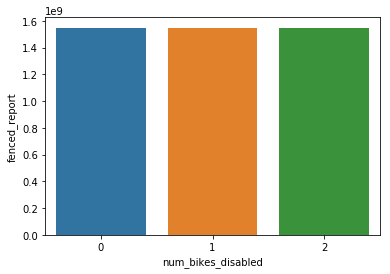

In [269]:
sns.barplot(bike_frame_open['num_bikes_disabled'],bike_frame_open['fenced_report'])


Below we examine the number of bikes and docks available for stations that have more need for repair. It makes sense that those with fewer docks are trending towards fewer repairs. We couldn't quite see this with correlations

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


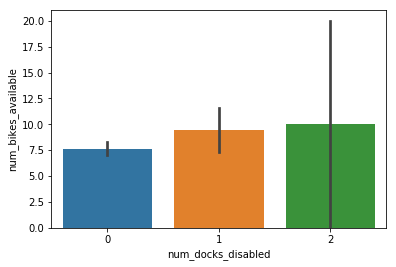

In [304]:
sns.barplot(bike_frame_open['num_docks_disabled'],bike_frame_open['num_bikes_available'])


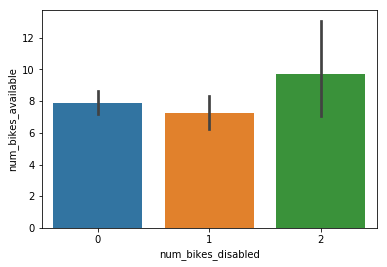

In [305]:
sns.barplot(bike_frame_open['num_bikes_disabled'],bike_frame_open['num_bikes_available'])


# The End!